In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
from scipy import optimize
import math
import collections

In [3]:
def split_partition(G, partition):
    Ga = G.subgraph(list(partition[0]))
    Gb = G.subgraph(list(partition[1]))
    return Ga, Gb

def node_index(H,i):
    '''Return the index of a given node.'''
    node_list = list(H.nodes())
    n = len(node_list)
    for j in range(n):
        if node_list[j] == i:
            return j

In [4]:
list1 = open("contact_Interaction.csv","rb")
MulG1 = nx.read_edgelist(list1,data=(("timestart", float),("timeend",float)),create_using=nx.MultiGraph)
list1.close()
G1 = nx.read_edgelist("contact_Interaction.csv",data=False)
out1 = nx.community.greedy_modularity_communities(G1)
print("modularity maximization, # of communities= ",len(out1))
Ga1,Gb1 = split_partition(G1,out1)
Ga2,Gb2 = split_partition(MulG1,out1)

modularity maximization, # of communities=  2


In [7]:
Ants = nx.read_edgelist("data/antsdata.csv",data=(("timestart", float),("timeend",float)))
MulAnts = nx.read_edgelist("data/antsdata.csv",data=(("timestart", float),("timeend",float)),create_using=nx.MultiGraph)

Text(0.5, 1.0, 'degree distribution in bee network')

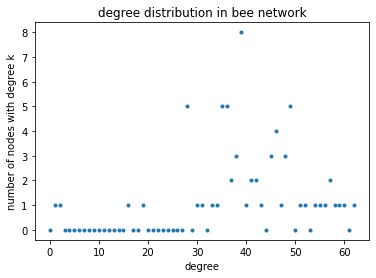

In [5]:
h = nx.degree_histogram(Ga1)
plt.plot(np.arange(len(h)),h,'.')
plt.xlabel("degree")
plt.ylabel("number of nodes with degree k")
plt.title("degree distribution in bee network")

Text(0.5, 1.0, 'degree distribution in ant network')

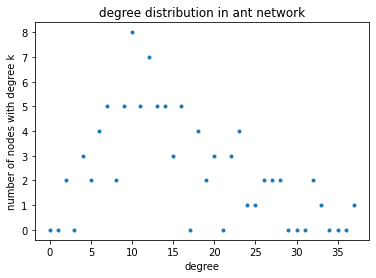

In [8]:
h = nx.degree_histogram(Ants)
plt.plot(np.arange(len(h)),h,'.')
plt.xlabel("degree")
plt.ylabel("number of nodes with degree k")
plt.title("degree distribution in ant network")

In [7]:
def network_at_t(G,t,timestep):
    edge_at_t = [(u,v) for (u,v,d) in G.edges(data=True) if d["timestart"] <= t]
    newedge_at_t = set([(u,v) for (u,v,d) in G.edges(data=True) if d["timestart"] > t and d["timestart"] < t+timestep])
    newGraph = nx.Graph()
    newGraph.add_edges_from(edge_at_t)
    new_edge_list = [e for e in newedge_at_t if (e[0],e[1]) not in newGraph.edges() and (e[1],e[0]) not in newGraph.edges()]
    return newGraph, new_edge_list

In [8]:
def interval(list,interval_length):
    upperbound = math.ceil(max(list))
    lowerbound = math.floor(min(list))
    number_of_interval = (upperbound-lowerbound)/interval_length + 1
    return upperbound,lowerbound,int(number_of_interval)

In [9]:
def degree_product_similarity(H):
    '''Return a matrix of degree product similarity.'''
    node_list = list(H.nodes())
    n = len(node_list)
    A = np.eye(n)
    for i in range(n):
        for j in range(n):
            A[i][j] = H.degree(node_list[i]) * H.degree(node_list[j])
    return A

In [10]:
def common_neighbour_similarity(G):
    '''Return a matrix of common neighbour similarity.'''
    node_list = list(G.nodes())
    n = len(node_list)
    A = np.eye(n)
    for i in range(n):
        for j in range(n):
            A[i][j] = len(set(G.adj[node_list[i]]).intersection(set(G.adj[node_list[j]])))
    return A

In [11]:
def similarity_relationship_at_t(G,t,timestep,interval_length,similarity,*o,split_slope=[0,5,None]):
    '''Return the slope of first and second line as well as the changing point of the distribution 
       of similarity of new added links from time t to t+timestep with a log-log plot.
    ----------------------------------------------------------------------------------------------
       Arguments:
       G: Graph
       t: the desired time
       timestep: the time interval
       interval_length: the width of intervals that the log similarity of new added links fall in
       similarity: the similarity desired
       split_slope: a list that split the curve into two parts, the first part starts from split_sope[0] 
       to split_slope[1] and second part is from split_slope[1] to split_slope[2]
        '''
    H,new_edge_t = network_at_t(G,t,timestep)
    node_listH = list(H.nodes())
    n = len(H.nodes())
    A = similarity(H,*o)
    s = []
    for e in new_edge_t:
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0) and A[e0][e1]:
            s.append(np.log(A[e0][e1]))
    upperbound,lowerbound,number_of_interval = interval(s,interval_length)
    hs = np.zeros(number_of_interval)   
    for e in new_edge_t:
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0)and A[e0][e1]:
            a = np.log(A[e0][e1])
            if upperbound < 0:
                hs[int(abs((a - upperbound)//interval_length))] += 1              
            else:
                hs[int(abs((a - lowerbound)//interval_length))] += 1
    xarray = np.linspace(lowerbound+interval_length/2,upperbound+interval_length/2,number_of_interval)
    zero_index = []
    for index in range(len(hs)):
        if not hs[index]:
            zero_index.append(index)
    xarray = np.delete(xarray,zero_index)
    hs = np.delete(hs,zero_index)
    cumhs = np.cumsum(hs/sum(hs))
    plt.figure()
    plt.plot(xarray,np.log(cumhs),'.')
    a,b = np.polyfit(xarray[split_slope[0]:split_slope[1]],np.log(cumhs[split_slope[0]:split_slope[1]]),1)
    plt.plot(xarray[split_slope[0]:split_slope[1]],a*xarray[split_slope[0]:split_slope[1]]+b,label=f"slope={a}")
    c, d = np.polyfit(xarray[split_slope[1]:split_slope[2]],np.log(cumhs[split_slope[1]:split_slope[2]]),1)
    plt.xlabel("log(k1k2)")
    plt.ylabel("log(p)")
    plt.title(f"log-log cdf of edge being added to k1k2 node pair at time {t}")
    plt.plot(xarray[split_slope[1]:split_slope[2]],c*xarray[split_slope[1]:split_slope[2]]+d,label=f"slope={c}")
    plt.legend()
    plt.figure()
    print("slope of first fit line =",a)
    print("slope of second fit line =",c)
    return a,c,xarray[split_slope[1]]

In [12]:
def p(G,t,timestep,interval_length,similarity,*o):
    '''Conditional probability that a link is added to node pair with given similarity scope.'''
    H,new_edge_t = network_at_t(G,t,timestep)
    node_listH = list(H.nodes())
    n = len(H.nodes())
    A = similarity(H,*o)
    s = []
    Hpotential_links = [(node_listH[j],node_listH[k]) for j in range(0,n) for k in range(j+1,n) \
                        if (node_listH[j],node_listH[k]) not in H.edges() and (node_listH[k],node_listH[j]) not in H.edges()]
    for e in Hpotential_links:
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0) and A[e0][e1]:
            s.append(np.log(A[e0][e1]))
    upperbound,lowerbound,number_of_interval = interval(s,interval_length)
    hs = np.zeros(number_of_interval)   
    for e in Hpotential_links:
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0) and A[e0][e1]:
            a = np.log(A[e0][e1])
            if upperbound < 0:
                hs[int(abs((a - upperbound)//interval_length))] += 1              
            else:
                hs[int(abs((a - lowerbound)//interval_length))] += 1
    hs2 = np.zeros(number_of_interval)   
    for e in new_edge_t:
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0)and A[e0][e1]:
            a = np.log(A[e0][e1])
            hs2[int(abs((a - lowerbound)//interval_length))] += 1
    xarray = np.linspace(lowerbound+interval_length/2,upperbound+interval_length/2,number_of_interval)
    zero_index = [i for i in range(number_of_interval) if not (hs[i] and hs2[i])]
    xarray = np.delete(xarray,zero_index)
    hs = np.delete(hs,zero_index)
    hs2 = np.delete(hs2,zero_index)
    plt.plot(xarray,hs2/hs,".")
    print(a)

6.992096427415888


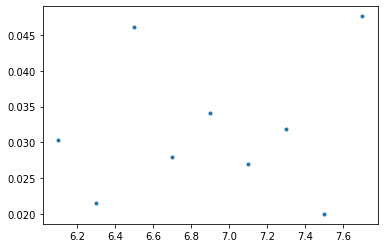

In [14]:
p(Ga2,5000,200,0.2,degree_product_similarity)

In [15]:
def similarity_histogram_at_t1(G,t,timestep,interval_length,similarity,*o):
    '''Plot similarity distribution of all node pairs(existing links and potential links) at time t.'''
    H,new_edge_t = network_at_t(G,t,timestep)
    node_listH = list(H.nodes())
    n = len(H.nodes())
    A = similarity(H,*o)
    s = []
    Hpotential_links = [(node_listH[j],node_listH[k]) for j in range(0,n) for k in range(j+1,n) \
                        if (node_listH[j],node_listH[k]) not in H.edges() and (node_listH[k],node_listH[j]) not in H.edges()]
    for index1 in range(len(H.nodes())):
        for index2 in range(index1+1,len(H.nodes())):
            if A[index1][index2]:
                s.append(np.log(A[index1][index2]))
    upperbound,lowerbound,number_of_interval = interval(s,interval_length)
    hs = np.zeros(number_of_interval)   
    for index1 in range(len(H.nodes())):
        for index2 in range(index1+1,len(H.nodes())):
            if A[index1][index2]:    
                a = np.log(A[index1][index2])
            if upperbound < 0:
                hs[int(abs((a - upperbound)//interval_length))] += 1              
            else:
                hs[int(abs((a - lowerbound)//interval_length))] += 1
    xarray = np.linspace(lowerbound+interval_length/2,upperbound+interval_length/2,number_of_interval)
    zero_index = []
    for index in range(len(hs)):
        if not hs[index]:
            zero_index.append(index)
    xarray = np.delete(xarray,zero_index)
    hs = np.delete(hs,zero_index)
    plt.plot(xarray,hs,'.')

In [16]:
def similarity_histogram_at_t(G,t,timestep,interval_length,similarity,*o):
    '''Plot distribution of potential links at time t.'''
    H,new_edge_t = network_at_t(G,t,timestep)
    node_listH = list(H.nodes())
    n = len(H.nodes())
    A = similarity(H,*o)
    s = []
    Hpotential_links = [(node_listH[j],node_listH[k]) for j in range(0,n) for k in range(j+1,n) \
                        if (node_listH[j],node_listH[k]) not in H.edges() and (node_listH[k],node_listH[j]) not in H.edges()]
    for e in Hpotential_links:
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0) and A[e0][e1]:
            s.append(np.log(A[e0][e1]))
    upperbound,lowerbound,number_of_interval = interval(s,interval_length)
    hs = np.zeros(number_of_interval)   
    for e in Hpotential_links:
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0) and A[e0][e1]:
            a = np.log(A[e0][e1])
            if upperbound < 0:
                hs[int(abs((a - upperbound)//interval_length))] += 1              
            else:
                hs[int(abs((a - lowerbound)//interval_length))] += 1
    xarray = np.linspace(lowerbound+interval_length/2,upperbound+interval_length/2,number_of_interval)
    zero_index = []
    for index in range(len(hs)):
        if not hs[index]:
            zero_index.append(index)
    xarray = np.delete(xarray,zero_index)
    hs = np.delete(hs,zero_index)
    return xarray, hs

In [17]:
def similarity_histogram_at_t2(G,t,timestep,interval_length,similarity,*o):
    '''Plot distribution of obseved links at time t.'''
    H,new_edge_t = network_at_t(G,t,timestep)
    node_listH = list(H.nodes())
    n = len(H.nodes())
    A = similarity(H,*o)
    s = []
    for e in H.edges():
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0) and A[e0][e1]:
            s.append(np.log(A[e0][e1]))
    upperbound,lowerbound,number_of_interval = interval(s,interval_length)
    hs = np.zeros(number_of_interval)   
    for e in H.edges():
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0) and A[e0][e1]:
            a = np.log(A[e0][e1])
            if upperbound < 0:
                hs[int(abs((a - upperbound)//interval_length))] += 1              
            else:
                hs[int(abs((a - lowerbound)//interval_length))] += 1
    xarray = np.linspace(lowerbound+interval_length/2,upperbound+interval_length/2,number_of_interval)
    zero_index = []
    for index in range(len(hs)):
        if not hs[index]:
            zero_index.append(index)
    xarray = np.delete(xarray,zero_index)
    hs = np.delete(hs,zero_index)
    return xarray,hs

In [18]:
def similarity_histogram_at_t3(G,t,timestep,interval_length,similarity,*o):
    '''Plot distribution of new added links at time t during time period timestep'''
    H,new_edge_t = network_at_t(G,t,timestep)
    node_listH = list(H.nodes())
    n = len(H.nodes())
    A = similarity(H,*o)
    s = []
    for e in new_edge_t:
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0) and A[e0][e1]:
            s.append(np.log(A[e0][e1]))
    upperbound,lowerbound,number_of_interval = interval(s,interval_length)
    hs = np.zeros(number_of_interval)   
    for e in new_edge_t:
        e0 = node_index(H,e[0])
        e1 = node_index(H,e[1])
        if (e0 or e0 == 0) and (e1 or e1 == 0) and A[e0][e1]:
            a = np.log(A[e0][e1])
            if upperbound < 0:
                hs[int(abs((a - upperbound)//interval_length))] += 1              
            else:
                hs[int(abs((a - lowerbound)//interval_length))] += 1
    xarray = np.linspace(lowerbound+interval_length/2,upperbound+interval_length/2,number_of_interval)
    zero_index = []
    for index in range(len(hs)):
        if not hs[index]:
            zero_index.append(index)
    xarray = np.delete(xarray,zero_index)
    hs = np.delete(hs,zero_index)
    return xarray,hs

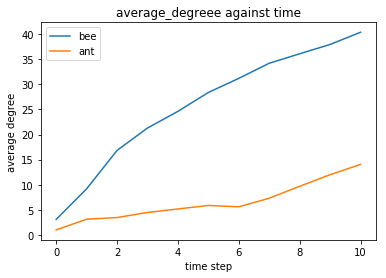

In [17]:
bee_average_degree = []
ant_average_degree = []
for n in range(11):
    G_bee,new_edge_g = network_at_t(Ga2,400+680*n,200)
    G_ant,_ = network_at_t(MulAnts,0+140*n,200)
    h = nx.degree_histogram(G_bee)
    h2 = nx.degree_histogram(G_ant)
    kbar = 0
    kbar2 = 0
    for i in range(len(h)):
        kbar += i*h[i]
    for i in range(len(h2)):
        kbar2 += i*h2[i]
    bee_average_degree.append(kbar/sum(h))
    ant_average_degree.append(kbar2/sum(h2))
plt.plot(np.arange(0,11,1),bee_average_degree,label="bee")
plt.plot(np.arange(0,11,1),ant_average_degree,label="ant")
plt.title("average_degreee against time")
plt.xlabel("time step")
plt.ylabel("average degree")
plt.legend()

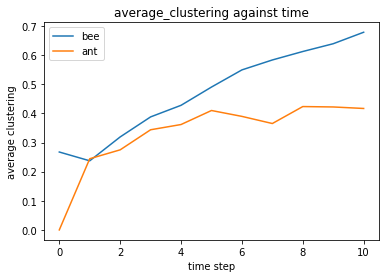

In [18]:
bee_average_clustering = []
ant_average_clustering = []
for n in range(11):
    G_bee,new_edge_g = network_at_t(Ga2,400+680*n,200)
    G_ant,_ = network_at_t(MulAnts,0+140*n,200)
    bee_average_clustering.append(nx.average_clustering(G_bee))
    ant_average_clustering.append(nx.average_clustering(G_ant))
plt.plot(np.arange(0,11,1),bee_average_clustering,label="bee")
plt.plot(np.arange(0,11,1),ant_average_clustering,label="ant")
plt.title("average_clustering against time")
plt.xlabel("time step")
plt.ylabel("average clustering")
plt.legend()

slope of first fit line = 4.130505809982923
slope of second fit line = 1.097539465742738


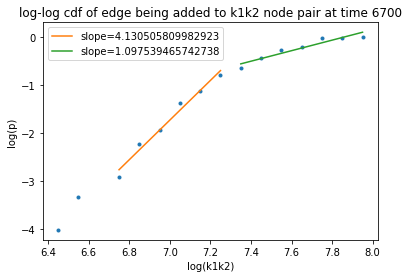

<Figure size 432x288 with 0 Axes>

In [155]:
a,c,s = similarity_relationship_at_t(Ga2,6700,500,0.1,degree_product_similarity,split_slope=[2,8,None])
# find the best fit first two parts by hand and append a,c,s to different lists

In [389]:
# dp_first_slope.append(a)
# dp_second_slope.append(c)
# changing_point.append(s)
print(dp_first_slope)
print(dp_second_slope)
print(changing_point)

[1.6287652922210214, 1.2781180330705195, 1.9052928236118527, 1.7524561732471182, 1.5637775274005108, 1.0938341868896362, 2.7018099233485935, 1.665101922872821, 1.2780143379290594, 2.7780385144971604, 1.7328679513998677, 3.4804998967504934, 2.0715673631957667, 2.478288273684468, 2.7286426378728335, 3.299790360636541, 2.0554360847087616, 1.7120367867076138, 3.401197381662158, 2.649209701079265, 2.181720390800258, 4.106767082220667, 5.004429410708041, 3.3771192281961873, 4.130505809982923]
[0.2527461411159165, 0.1916482778154568, 0.10471354288135576, 0.16627971413552975, 0.1536717309934279, 0.16672843624668024, 0.17927153357812375, 0.21224525396351698, 0.08601206342241931, 0.28086513098867005, 0.31803932390421863, 0.3005344349337305, 0.24481576648278153, 0.2589547352703092, 0.3899238489525921, 0.6512121694239029, 0.35189739034819617, 0.23320370124282463, 0.34598496250851823, 0.3714922893868281, 0.27979777530886285, 0.6884962493972863, 0.7061769758829659, 0.39343519989204795, 1.09753946574

In [390]:
np.save("dp1",dp_first_slope)
np.save("dp2",dp_second_slope)
np.save("dp3",changing_point)

In [21]:
dp_first_slope = np.load("dp1.npy")
dp_second_slope= np.load("dp2.npy")
changing_point = np.load("dp3.npy")

In [23]:
time_span = np.array(list(range(1000,5100,200))+list(range(5200,6800,500)))

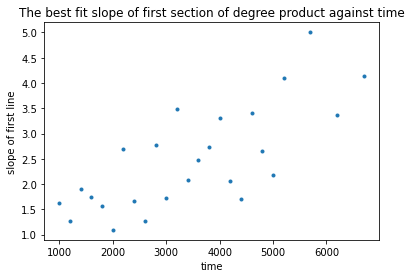

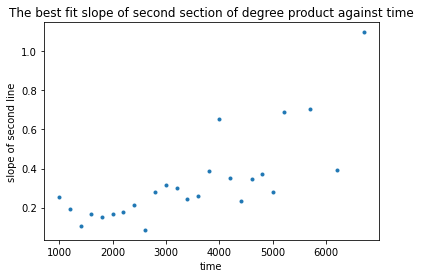

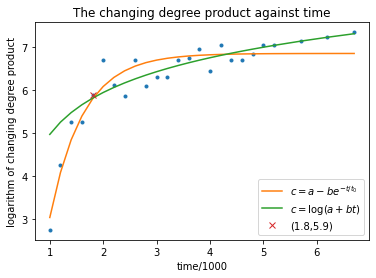

In [44]:
plt.plot(time_span,dp_first_slope,".")
plt.title("The best fit slope of first section of degree product against time")
plt.xlabel("time")
plt.ylabel("slope of first line")
plt.figure()
plt.plot(time_span,dp_second_slope,".")
plt.title("The best fit slope of second section of degree product against time")
plt.xlabel("time")
plt.ylabel("slope of second line")
plt.figure()
plt.plot(time_span/1000,changing_point,".")
plt.title("The changing degree product against time")
plt.plot(time_span/1000,f(time_span/1000,a,b,t0),label=r"$c=a-be^{-t/t_0}$")
plt.plot(time_span/1000,np.log(A*time_span/1000+B),label=r"$c=\log(a+bt)$")
plt.plot(time_span[4]/1000,changing_point[4],"x",label=f"({time_span[4]/1000},{changing_point[4]})")
plt.xlabel("time/1000")
plt.ylabel("logarithm of changing degree product")
plt.legend()

In [25]:
def f(x,a,b,c):
    return a-b*np.exp(-x/c)

In [92]:
A,B = np.polyfit(time_span[6:]/1000,np.exp(changing_point[6:]),1)

In [90]:
a,b,t0 = optimize.curve_fit(f,time_span/1000,changing_point)[0]

In [93]:
print(A,B)

238.49492623372365 -94.01767085703764


In [46]:
print(a,b,t0)

6.8565255402519325 18.950468304706803 0.6240970511448043


In [55]:
abar = np.mean(dp_first_slope)
bbar = np.mean(dp_second_slope)
cpbar = np.mean(changing_point)
print(bbar)

NameError: name 'dp_first_slope' is not defined

-94.01767085703764
4 1.1 7.33154992176929


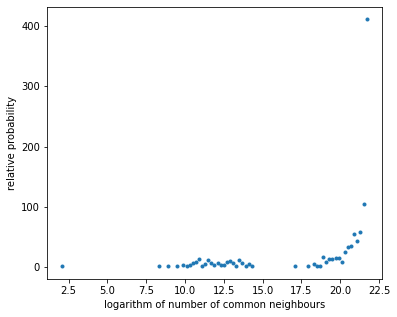

In [95]:
plt.figure(figsize=(6,5))
xa2,ya2=similarity_histogram_at_t(Ga2,6800,200,0.2,adjust_degree_product,6800)
plt.xlabel("logarithm of number of common neighbours")
plt.ylabel("relative probability")
plt.plot(xa2,ya2,".")

In [108]:
def dp(t):
    if t >= 1000 and  t < 3000:
        a = 1.5
    elif t >= 3000 and t < 5000:
        a = 2.5
    elif t >= 5000 and t <= 7200:
        a = 4
    if t >= 1000 and t < 5000:
        b = 0.3
    else:
        b = 1/2000 * t - 2.3
    if t <= 1800:    
        c = f(t/1000,6.8565255402519325,18.950468304706803,0.6240970511448043)
    else:
        c = np.log(A*t/1000+B)
        print(B)
    return a,b,c
dp(2000)

-94.01767085703764


(1.5, 0.3, 5.947962353671758)

In [121]:
def adjust_degree_product(G,t):
    a,b,c = dp(t)
    print(a,b,c)
    A = degree_product_similarity(G)
    B = A.copy()
    for i in range(len(A)):
        for j in range(len(A)):
            if A[i][j] and np.log(A[i][j]) < c-0.1:
                B[i][j] = A[i][j]**(a-1)
            elif A[i][j] and abs(c-np.log(A[i][j])) <= 0.1:
                B[i][j] = (np.exp(c-0.1))**(a-1)
            elif A[i][j] and np.log(A[i][j]) > c+0.1:
                B[i][j] = A[i][j]**(b-1) * (np.exp(c-0.1)) **(a-b)
    return B

In [129]:
def adjust_degree_product(G,t):
    a,b,c = dp(t)
    print(a,b,c)
    A = degree_product_similarity(G)
    B = A.copy()
    for i in range(len(A)):
        for j in range(len(A)):
            if A[i][j] and np.log(A[i][j]) < c:
                B[i][j] = A[i][j]**(a-1)
            elif A[i][j] and np.log(A[i][j]) > c:
                B[i][j] = A[i][j]**(b-1) * np.exp(c) **(a-b)
    return B

In [79]:
Gt,new_edges = network_at_t(Ga2,7000,200)
node_list = list(Gt.nodes())
edge_list = list(Gt.edges())
B = adjust_degree_product(Gt,7000)
n = len(Gt.nodes())
rank_list = [B[i][j] for i in range(n) for j in range(i+1,n) if (node_list[i],node_list[j]) not in edge_list and 
                 (node_list[j],node_list[i]) not in edge_list]
rank_list.sort(reverse=True)

4 1.2000000000000002 7.3622942016805


In [384]:
def node_index(H,i):
    '''Return the index of a given node.'''
    node_list = list(H.nodes())
    n = len(node_list)
    for j in range(n):
        if node_list[j] == i:
            return j
print([B[node_index(Gt,e[0])][node_index(Gt,e[1])] for e in new_edges if e[0] in list(Gt.nodes()) and e[1] in list(Gt.nodes())])

[1820316861.0, 3290607813.0861316, 2299968000.0, 3312124007.1650977, 3198692683.4823813, 1177583616.0, 3096570566.5671678, 2973952661.6126957, 3176124695.781205, 2176782336.0, 337153536.0, 2331473976.0, 3199310549.606035, 2973952661.6126957, 3170381213.888296, 3102180332.6423893, 3288120578.33594, 3184348191.881348, 2363266368.0, 3312124007.1650977, 2973952661.6126957, 2973952661.6126957, 2973952661.6126957, 3209741971.5202537, 1820316861.0, 700227072.0, 3233173232.977319, 2973952661.6126957, 2973952661.6126957, 3104273573.638731, 1540798875.0, 2973952661.6126957, 876467493.0, 3305104444.1877174]


-94.01767085703764
4 1.0500000000000003 7.315815905754902


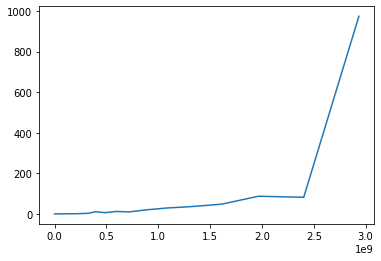

In [130]:
xa,ya=similarity_histogram_at_t2(Ga2,6700,500,0.2,adjust_degree_product,6700)
plt.plot(np.exp(xa-0.1),ya)

In [21]:
def average_degree(G):
    kbar = 0
    h = nx.degree_histogram(G)
    for n in range(len(h)):
        kbar += h[n]*n
    return kbar/len(G.nodes())

In [22]:
def average_rec(colony):
    kbar = 0
    ac = 0
    for n in range(1,6):
        ghrg = nx.read_edgelist(f"data/rc{colony}{n}.csv")
        kbar += average_degree(ghrg)
        ac += nx.average_clustering(ghrg)
    return kbar/5,ac/5

In [ ]:
print("recontructed average_degree=",average_rec("bee")[0])
print("real average_degree=",average_degree(Ga1))

In [ ]:
print("recontructed average_clustering=",average_rec("bee")[1])
print("real average_clustering=",nx.average_clustering(Ga1))

In [ ]:
print("recontructed average_degree=",average_rec("ant")[0])
print("real average_degree=",average_degree(Ants))

In [ ]:
print("recontructed average_clustering=",average_rec("ant")[1])
print("real average_clustering=",nx.average_clustering(Ants))

In [ ]:
len(network_at_t(Ga2,5000,3000)[1])

# Analysis

In [159]:
def plot(G,t,timestep,interval_length,similarity,*o):
    x1,y1 = similarity_histogram_at_t2(Ga2,3000,200,0.5,degree_product_similarity)
    x2,y2 = similarity_histogram_at_t(Ga2,3000,200,0.5,degree_product_similarity)
    x3,y3 = similarity_histogram_at_t3(Ga2,3000,200,0.5,degree_product_similarity)
    fig,ax1 = plt.subplots()
    ax1.plot(x1,y1,'.',label="missing links")
    ax1.set_xlabel(f"logarithm of {similarity.__name__}")
    ax1.set_ylabel("number of node pairs")
    fig.suptitle(f"Distribution of {similarity.__name__} at time {t}")
    ax1.plot(x2,y2,'x',label="current network")
    ax1.legend()
    ax2 = plt.axes([0,0,1,1])
    ip = InsetPosition(ax1, [0.1,0.3,0.5,0.5])
    ax2.set_axes_locator(ip)
    ax2.plot(x3,y3,'v',label="new added links")
    ax2.legend()

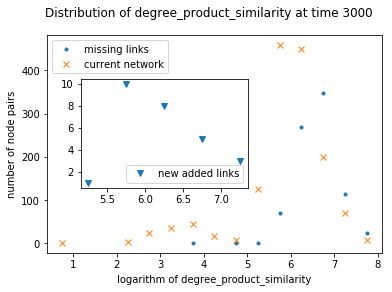

In [160]:
plot(Ga2,3000,200,0.5,degree_product_similarity)

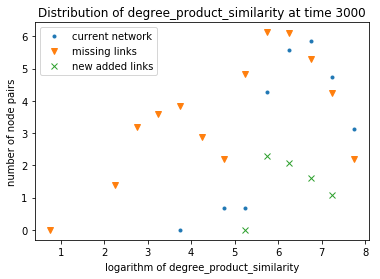

In [32]:
similarity_histogram_at_t2(Ga2,3000,200,0.5,degree_product_similarity)
similarity_histogram_at_t(Ga2,3000,200,0.5,degree_product_similarity)
similarity_histogram_at_t3(Ga2,3000,200,0.5,degree_product_similarity)

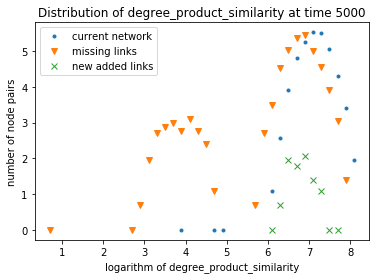

In [55]:
similarity_histogram_at_t2(Ga2,5000,200,0.2,degree_product_similarity)
similarity_histogram_at_t(Ga2,5000,200,0.2,degree_product_similarity)
similarity_histogram_at_t3(Ga2,5000,200,0.2,degree_product_similarity)

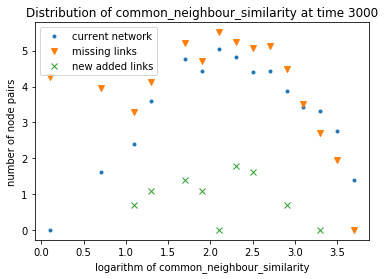

In [53]:
similarity_histogram_at_t2(Ga2,3000,200,0.2,common_neighbour_similarity)
similarity_histogram_at_t(Ga2,3000,200,0.2,common_neighbour_similarity)
similarity_histogram_at_t3(Ga2,3000,200,0.2,common_neighbour_similarity)

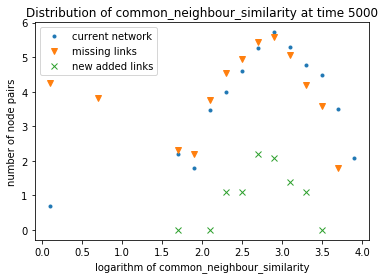

In [52]:
similarity_histogram_at_t2(Ga2,5000,200,0.2,common_neighbour_similarity)
similarity_histogram_at_t(Ga2,5000,200,0.2,common_neighbour_similarity)
similarity_histogram_at_t3(Ga2,5000,200,0.2,common_neighbour_similarity)